---
<center> <b>NODE2VEC</b></center>

---

Paper: "node2vec: Scalable Feature Learning for Networks", Aditya Grover, Jure Leskovec, https://arxiv.org/pdf/1607.00653.pdf


# Imports 

In [288]:
import numpy as np
import pandas as pd
import time
import random
from scipy.sparse import csr_matrix
import networkx as nx
from sklearn.metrics import pairwise_distances
from tqdm.notebook import tqdm, trange
from sklearn.manifold import TSNE

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# RandomWalkGenerator

In [2]:
class RandomWalkGenerator:
  def __init__(self, g, p, q, l):
    """RandomWalkGeneration

    Generating random walks for feature learning.

    Args: 
    :param g: networkx graph;
    :param p: p parameter;
    :param q: q parameter;
    :param l: length of a sequence.

    """
    # Params
    self.pi = 1/p
    self.qi = 1/q
    self.l  = l 

    E = nx.linalg.graphmatrix.adjacency_matrix(g)

    # In One
    self.A1 = E > 0 
    # In Two
    self.A2 = E @ E > 0

    # Size
    self.n = E.shape[0]

  def generate_walks(self):
    """generate_walks
    
    From all nodes.

    """
    return np.array([self.generate_random_walk(i) for i in range(self.n)])


  def generate_random_walk(self, v):
    """generate_random_walk

    Generates a random walk.

    Args: 
    :param v: starting node index.
    """

    # New Walk
    walk = [None for _ in range(self.l)]

    # Initial Node
    walk[0] = v
    
    # First Step
    walk[1] = np.random.choice(self.A1[v, :].indices)
    
    # Next Steps
    for i in range(2, self.l):

      a1      = self.A1[walk[i-1], :]
      a1_prev = self.A2[walk[i-2], :]
      a2_prev = self.A2[walk[i-2], :]

      prob=np.zeros(self.n)

      # set all weights to one
      prob[a1.indices]=1
      
      # set weight of nodes wchich can be reached from previous only at two steps to qi.
      prob[(a2_prev>a1_prev).multiply(a1).indices]=self.qi
      
      # set weight to previous node to pi
      prob[walk[i-2]]=self.pi

      # normalize probablity
      prob=prob/np.sum(prob)
      
      # go to new node
      walk[i]=np.random.choice(range(self.n), p=prob)

    return np.array(walk)

# DataSet

## Positive Samples

In [3]:
class PositiveSamples(torch.utils.data.Dataset):
  def __init__(self, walks):
    super(PositiveSamples, self).__init__() 

    X = []
    for a in walks:
      X.append(torch.tensor([(a[i], a[j]) for i in range(len(a)) for j in range(i+1, len(a))]))

    self.X = torch.cat(X)
    self.len = self.X.shape[0]

  def __getitem__(self, idx):
    return self.X[idx]
    
  def __len__(self):
    return self.len

In [4]:
def test_positive_samples():
  p = PositiveSamples(walks)
  return p[0], p

## Negative Samples

In [5]:
class NegativeSamples:

  def __init__(self, walks, n):

    self.n = n
    self.p = np.zeros(n)
    for a in walks:
      self.p[a] += 1

    self.p = self.p**(3/4)
    self.p = self.p / self.p.sum()

  def sample(self, n=1):
    return np.random.choice(self.n, n, p=self.p, replace=False)

  def sample_torch(self, v, n):
    return torch.column_stack((
        torch.full((n,), v),
        torch.tensor(self.sample(n))
    ))


In [6]:
def test_negative_samples():
  ns = NegativeSamples(walks, 10)
  print(ns.p)
  print(ns.sample(3))
  print(ns.sample_torch(2,3))
  return ns

# Word2Vec

In [7]:
from torch.nn import init
class Word2Vec(torch.nn.Module):

    def __init__(self, n, dim):
        super(Word2Vec, self).__init__()

        # Parameters 
        self.n = n
        self.dim = dim

        # U and V matrices
        self.U = torch.nn.Embedding(n, dim, sparse=True)
        self.V = torch.nn.Embedding(n, dim, sparse=True)

        init.uniform_(self.U.weight.data, -1/dim, 1/dim)
        init.constant_(self.V.weight.data, 0)

    def forward(self, UV):
        U = self.U(UV[:,0])
        V = self.V(UV[:,1])

        return (U*V).sum(1).clamp(-10,10).sigmoid()

# Simple K-Means Demo  

In [364]:
class KMeans:
    def __init__(self, X, k, metric="cosine", normalize=True):
        self.k = k
        self.X = X
        self.vX = (X*X).sum(1).sqrt()
        dist = pairwise_distances(X.numpy(), metric=metric)
        I = [np.random.randint(X.shape[0])]
        for i in range(k-1):
            I.append(dist[I].min(axis=0).argmax())

        self.C = X[I].unsqueeze(1)
        self.normalize = normalize
    def vC(self):
        return (self.C*self.C).sum(2).sqrt()
    def predict(self):
        if self.normalize:
            return (self.X*self.C).sum(2).div(self.vX*self.vC()).argmax(0)
        else:
            return (self.X*self.C).sum(2).argmax(0)
    def step(self):
        c = self.predict()
        cs = []
        for k in range(self.k):
            if self.normalize:
                x = self.X[c==k]
                ck = x.mean(0).nan_to_num()
                ck /= ck.norm().clip(0.001)
                ck *= x.norm(dim=1).mean().nan_to_num()
                cs.append(ck)
            else:
                cs.append(self.X[c==k].mean(0))

        self.C = torch.vstack(cs).unsqueeze(1)

    def run(self, n):
        for _ in range(n):
            self.step()
    

# All in one function

In [365]:
def Node2Vec(G, p, q, l, k, dim, metric="cosine", EPOCHS = 3, DIFF_WALKS=10, device="cuda"):
    """Node2Vec

    Generate communities for Graph.

    Args: 
    :param G: networkx graph;
    :param p: p parameter;
    :param q: q parameter;
    :param l: length of a sequence.
    :param k: number of communities.
    :param dim: number of dimensions.
    :param EPOCHS: number of epochs.
    :param DIFF_WALKS: number of diffrent work per node.
    :param device: device for torch.
    """
    
    rng = RandomWalkGenerator(G, p, q, l)

    n_g = len(G.nodes)
    m = Word2Vec(n_g, dim)

    opt = torch.optim.SparseAdam(m.parameters(), lr=0.01)
    
    pbar = trange(EPOCHS)
    for i in pbar:

        walks = np.vstack([rng.generate_walks() for _ in range(DIFF_WALKS)])
        pds = PositiveSamples(walks)
        ns = NegativeSamples(walks, n_g)
        dl = torch.utils.data.DataLoader(pds, batch_size=100, shuffle=True)

        epoch_loss = 0 
        for p in tqdm(dl): 

            n = torch.vstack([
            ns.sample_torch(i, 4)
            for i in p[:,0]
          ])

            p_p = m(p)
            n_p = m(n)

            L = -(p_p.log().sum() + (1-n_p).log().sum())/(p_p.shape[0] + n_p.shape[0])

            m.zero_grad()
            L.backward()
            opt.step()

            pbar.set_description(f"L: {L.item():.03f}")

    points = m.U.weight.data       
    kmeans = KMeans(points, k, metric=metric)
    kmeans.run(100)
    return kmeans

# D1

In [327]:
d = pd.read_csv('D1-K=2.csv', header=None).to_numpy()

In [328]:
D = nx.convert_matrix.from_numpy_matrix(d)

In [329]:
start_time = time.time()
comm = Node2Vec(D, p=10, q=5, l=10, k=2, dim=3)
total_time=time.time() - start_time

In [330]:
print('total time:', total_time)

df=pd.DataFrame({"node":np.arange(len(D.nodes))+1,"comm":comm.predict().numpy()+1})

df.to_csv("Olaf_Werner_Bogdan_Jastrzebski/D1-K=2.csv",header=False,index=False)

total time: 18.75500512123108


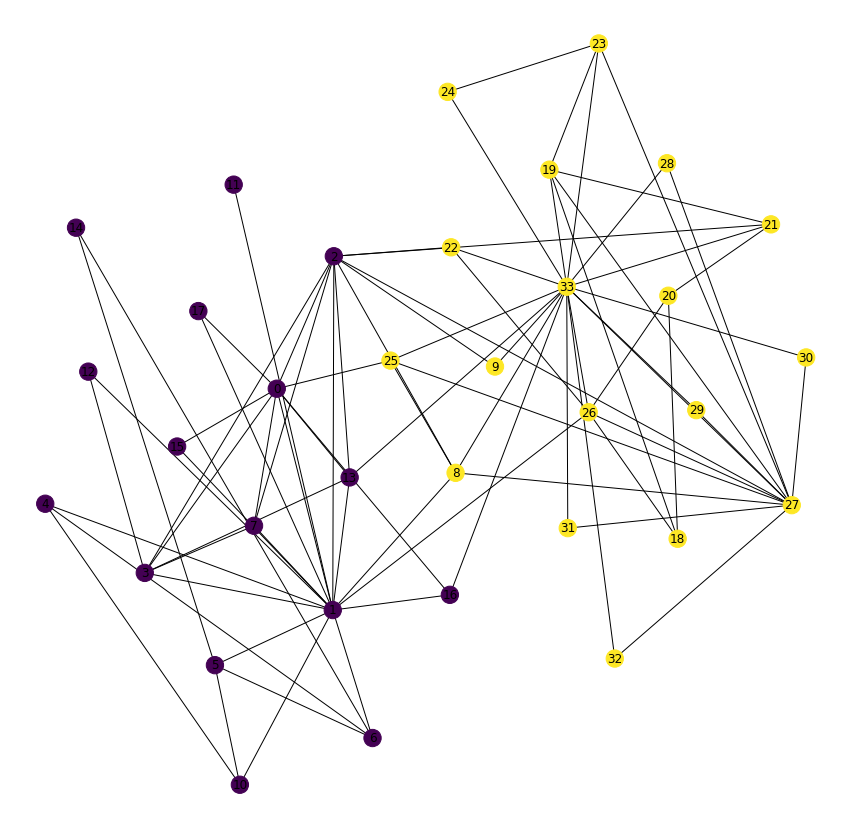

In [331]:
X_embedded = TSNE(
    n_components=2, init='random').fit_transform(comm.X.numpy())
fig,ax=plt.subplots(figsize=(15,15))
nx.draw(D, pos=X_embedded, with_labels=True, node_color=comm.predict().numpy())

# D2

In [427]:
d = pd.read_csv('D2-K=7.csv', header=None).to_numpy()

In [428]:
D = nx.convert_matrix.from_numpy_matrix(d)

In [429]:
start_time = time.time()
comm = Node2Vec(D, p=10, q=15, l=5, k=7, dim=30, EPOCHS=4)
total_time=time.time() - start_time

In [430]:
print('total time:', total_time)

df=pd.DataFrame({"node":np.arange(len(D.nodes))+1,"comm":comm.predict().numpy()+1})

df.to_csv("Olaf_Werner_Bogdan_Jastrzebski/D2-K=7.csv",header=False,index=False)

total time: 13.592886924743652


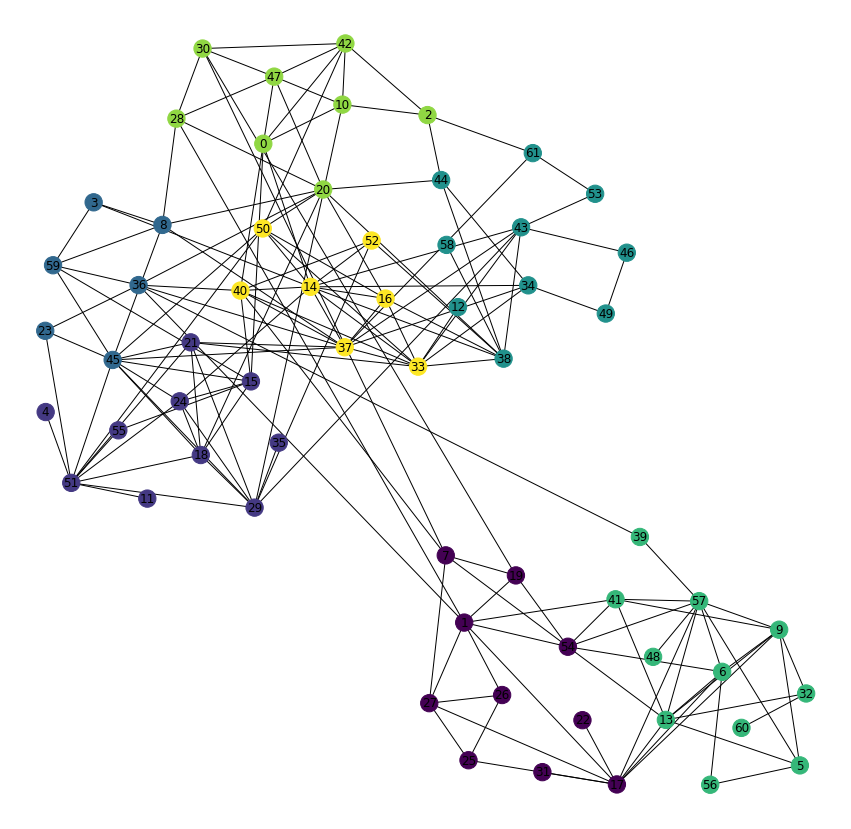

In [431]:
X_embedded = TSNE(
    n_components=2, init='random').fit_transform(comm.X.numpy())
fig,ax=plt.subplots(figsize=(15,15))
nx.draw(D, pos=X_embedded, with_labels=True, node_color=comm.predict().numpy())

# D3

In [349]:
d = pd.read_csv('D3-K=12.csv', header=None).to_numpy()

In [350]:
D = nx.convert_matrix.from_numpy_matrix(d)

In [351]:
start_time = time.time()
comm = Node2Vec(D, p=10, q=5, l=10, k=12, dim=23)
total_time=time.time() - start_time

In [352]:
print('total time:', total_time)

df=pd.DataFrame({"node":np.arange(len(D.nodes))+1,"comm":comm.predict().numpy()+1})

df.to_csv("Olaf_Werner_Bogdan_Jastrzebski/D3-K=12.csv",header=False,index=False)

total time: 63.837902307510376


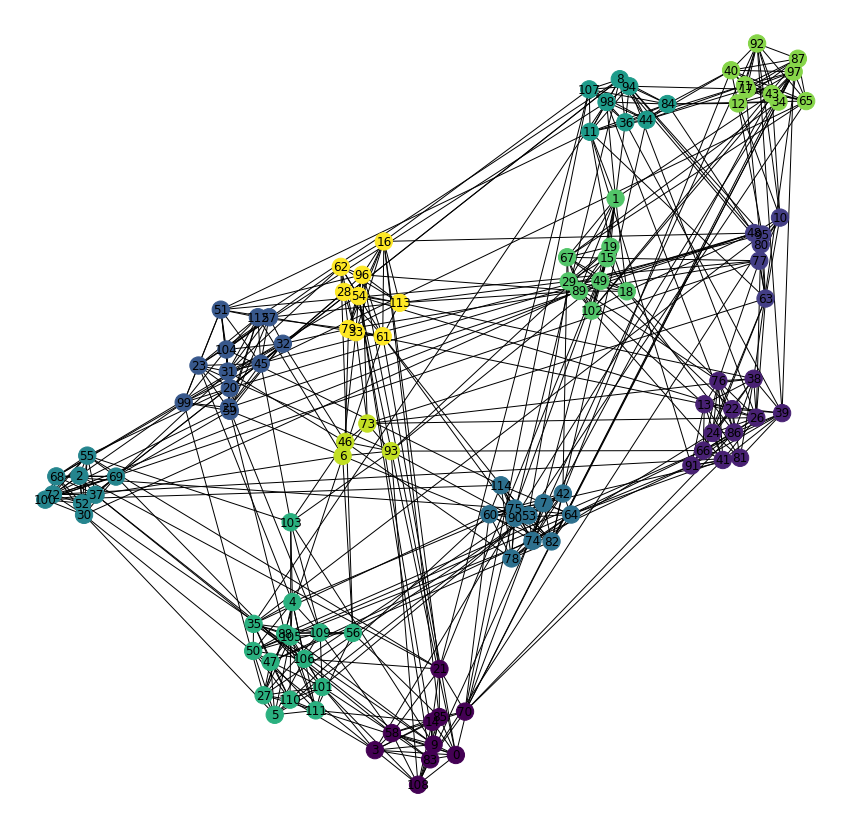

In [353]:
X_embedded = TSNE(
    n_components=2, init='random').fit_transform(comm.X.numpy())
fig,ax=plt.subplots(figsize=(15,15))
nx.draw(D, pos=X_embedded, with_labels=True, node_color=comm.predict().numpy())

# D1 UNC

In [393]:
d = pd.read_csv('D1-UNC.csv', header=None).to_numpy()

In [394]:
D = nx.convert_matrix.from_numpy_matrix(d)

In [395]:
start_time = time.time()
comm = Node2Vec(D, p=10, q=25, l=10, k=25, dim=30)
total_time=time.time() - start_time

In [396]:
print('total time:', total_time)

df=pd.DataFrame({"node":np.arange(len(D.nodes))+1,"comm":comm.predict().numpy()+1})

df.to_csv("Olaf_Werner_Bogdan_Jastrzebski/D1-UNC.csv",header=False,index=False)

total time: 68.7733862400055


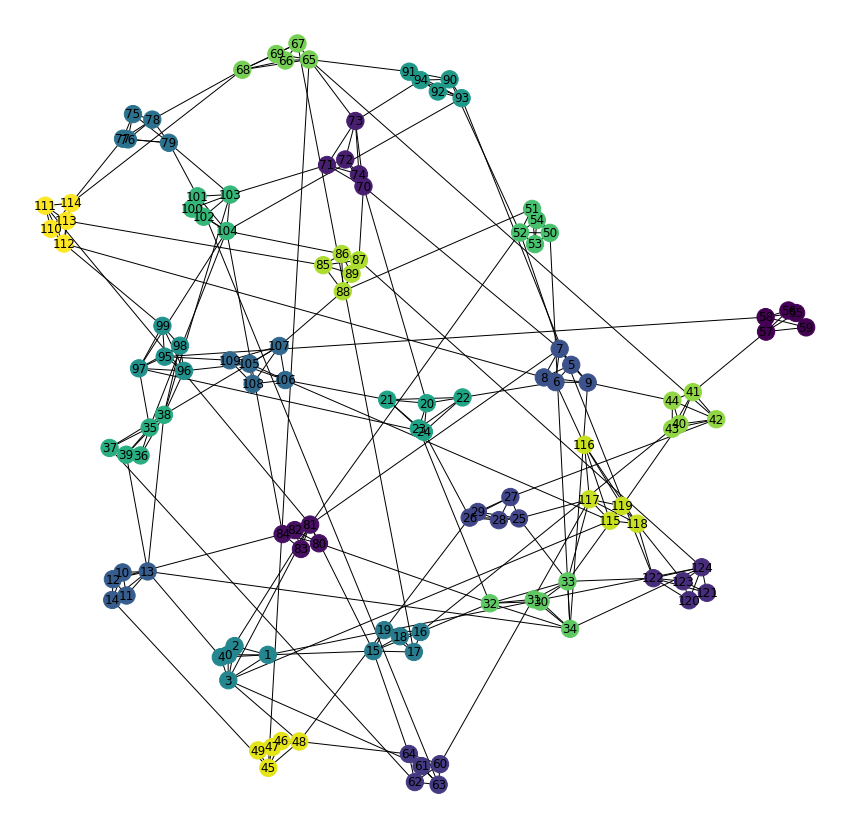

In [397]:
X_embedded = TSNE(
    n_components=2, init='random').fit_transform(comm.X.numpy())
fig,ax=plt.subplots(figsize=(15,15))
nx.draw(D, pos=X_embedded, with_labels=True, node_color=comm.predict().numpy())

# D2 UNC

In [367]:
d = pd.read_csv('D2-UNC.csv', header=None).to_numpy()

In [368]:
D = nx.convert_matrix.from_numpy_matrix(d)

In [369]:
start_time = time.time()
comm = Node2Vec(D, p=10, q=15, l=10, k=15, dim=30)
total_time=time.time() - start_time

In [370]:
print('total time:', total_time)

df=pd.DataFrame({"node":np.arange(len(D.nodes))+1,"comm":comm.predict().numpy()+1})

df.to_csv("Olaf_Werner_Bogdan_Jastrzebski/D2-UNC.csv",header=False,index=False)

total time: 84.18866515159607


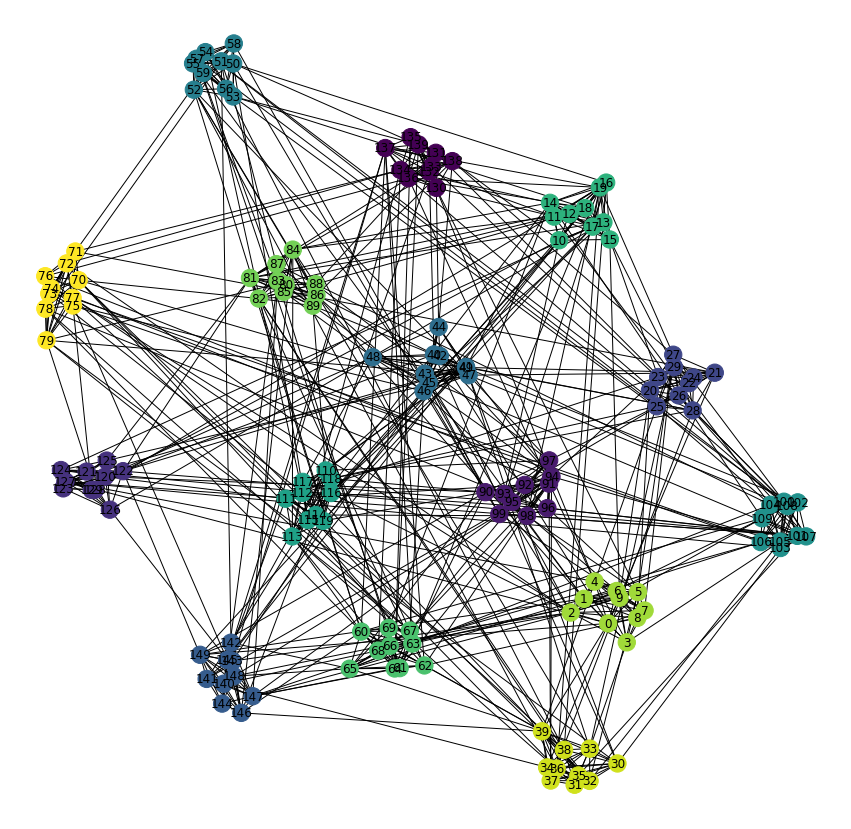

In [371]:
X_embedded = TSNE(
    n_components=2, init='random').fit_transform(comm.X.numpy())
fig,ax=plt.subplots(figsize=(15,15))
nx.draw(D, pos=X_embedded, with_labels=True, node_color=comm.predict().numpy())

# D3 UNC

In [377]:
d = pd.read_csv('D3-UNC.csv', header=None).to_numpy()

In [378]:
D = nx.convert_matrix.from_numpy_matrix(d)

In [385]:
start_time = time.time()
comm = Node2Vec(D, p=10, q=5, l=10, k=9, dim=30, EPOCHS=2)
total_time=time.time() - start_time

In [386]:
print('total time:', total_time)

df=pd.DataFrame({"node":np.arange(len(D.nodes))+1,"comm":comm.predict().numpy()+1})

df.to_csv("Olaf_Werner_Bogdan_Jastrzebski/D3-UNC.csv",header=False,index=False)

total time: 29.765385150909424


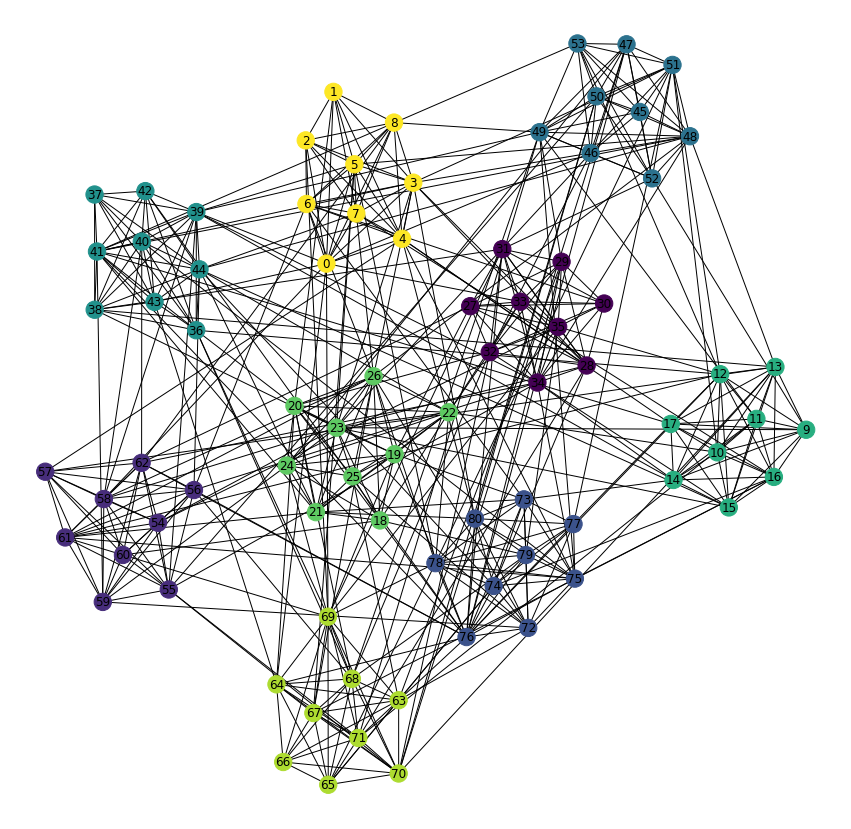

In [387]:
X_embedded = TSNE(
    n_components=2, init='random').fit_transform(comm.X.numpy())
fig,ax=plt.subplots(figsize=(15,15))
nx.draw(D, pos=X_embedded, with_labels=True, node_color=comm.predict().numpy())